# I am having to much difficulty figuring out the current task.
### What I am having issues with:
With scipy.optimize you have to pass all the variables through and with trying to use basis functions to generate the paths, scipy.optimize will try to optimize the time variable as well. However I am trying to fix the manuever to last the entire duration of the time variable and not optimize that one. I've tried fixed the problem with switching contraints with bounds and doing a mix of both, but nothing seems to work. I am missing a critical piece to the puzzle. What I ended up doing is disreguarding the basis functions and only have moment and thrust as constants in order to get an actual manuever. 

### Where the critical piece lies:
The main complexity is the dynamics is a second order constraint, and the fact that when I tried to create an array of 9 variables to linearize the problem I ran into one main issue; $\theta$ must not be assumed to be as small angle. Therefore nullifying the linearization attempt!

### Second Order NN
I tried a few things but the closest I could think about doing was creating a double gradient. However, this will approach the dissappearing gradient problem much sooner and if it ran properly would most likely never get to a close enough solution.

## I don't understand what piece of the puzzle I am missing and I wished I had more time to try to figure it out


Optimized coefficients: [ 4.69784614e-01  2.26069937e-01 -1.60265635e-01 -4.94869376e-01
  4.77220440e-01  5.39354940e-01 -2.57920571e-01  3.02091182e-02
  9.15742836e-01 -7.51854304e-01  1.81388286e-04  2.65819562e-03
 -1.52218521e-03  1.63730059e-02 -2.05635952e-02  4.28573390e-01
 -6.50783764e-05  4.51636126e-02  6.38845604e-02 -9.12249914e-02
 -2.10769808e-06  4.21713785e-05 -1.71655833e-04  1.05175995e-03
 -1.01509708e-03]


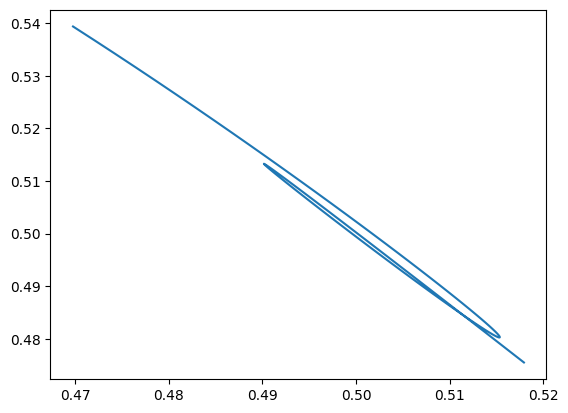

In [1]:
### Basis function attempt
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M = np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5)
alpha_guess = np.hstack((alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M))
initial_conditions = np.array([0.0,0.0,0.0,0.0,0.0]) # x,y,theta,T,M
final_conditions = np.array([1.0,1.0,0.0,0.9,0.0]) # x,y,theta,T,M

def generate_polynomial_basis(t):
  degree = 4
  basis_functions = []
  for d in range(degree + 1):
    basis_functions.append(t**d)
  basis_functions = np.array(basis_functions).T
  derivative_basis_functions = np.zeros_like(basis_functions)
  for d in range(degree):
    derivative_basis_functions[:, d] = (d + 1) * basis_functions[:, d + 1]
  second_derivative_basis_functions = np.zeros_like(basis_functions)
  for d in range(degree - 1):
    second_derivative_basis_functions[:, d] = (d + 1) * derivative_basis_functions[:, d + 1]
  return basis_functions, derivative_basis_functions, second_derivative_basis_functions
t = np.linspace(0, 1, 100)  # normalized Time
basis_functions, derivative_basis_functions, second_derivative_basis_functions = generate_polynomial_basis(t)
def Error(alpha):
  mass = 1
  inertia_z = 1
  alpha_x_slice = alpha[:5]
  alpha_y_slice = alpha[5:2*5]
  alpha_theta_slice = alpha[2*5:3*5]
  alpha_T = alpha[3*5:4*5]
  alpha_M = alpha[4*5:25]
  error_x = np.sum((mass * second_derivative_basis_functions @ alpha_x_slice - \
                    basis_functions @ alpha_T * np.cos(basis_functions @ alpha_theta_slice))**2)
  error_y = np.sum((mass * second_derivative_basis_functions @ alpha_y_slice - \
                    basis_functions @ alpha_T * np.sin(basis_functions @ alpha_theta_slice))**2)
  error_M = np.sum((inertia_z * second_derivative_basis_functions @ alpha_theta_slice - basis_functions @ alpha_M)**2)

  error_IC = np.sum((basis_functions @ alpha_x_slice - initial_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - initial_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - initial_conditions[2])**2 + \
                    (basis_functions @ alpha_T - initial_conditions[3])**2 + \
                    (basis_functions @ alpha_M - initial_conditions[4])**2)
  error_FC = np.sum((basis_functions @ alpha_x_slice - final_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - final_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - final_conditions[2])**2 + \
                    (basis_functions @ alpha_T - final_conditions[3])**2 + \
                    (basis_functions @ alpha_M - final_conditions[4])**2)
  J = error_x + error_y + error_M + 10*error_IC + 10*error_FC
  return J

def x(time):
  generate_polynomial_basis(time)[0]@alpha_guess[:5]
def y(time):
  generate_polynomial_basis(time)[0]@alpha_guess[5:2*5]
def theta(time):
  generate_polynomial_basis(time)[0]@alpha_guess[2*5:3*5]
def T(time):
  generate_polynomial_basis(time)[0]@alpha_guess[3*5:4*5]
def M(time):
  generate_polynomial_basis(time)[0]@alpha_guess[4*5:5*5]

# Initial guess for alpha
alpha_guess = np.zeros(25)

# Minimize the error function
result = minimize(Error, alpha_guess, options={'maxiter': 10000})

# Extract the optimized coefficients
optimized_alpha = result.x

# Print the result
print("Optimized coefficients:", optimized_alpha)
plt.plot(np.dot(basis_functions,optimized_alpha[:5]),np.dot(basis_functions,optimized_alpha[5:10]))
plt.show()
#plt.plot(t,np.dot(generate_polynomial_basis(t)[0],optimized_alpha[5:10]))
#plt.show()

Optimal T: 0.399819249530761
Optimal M: 0.09554763676787789
(6, 100)


Text(0.5, 1.0, 'Generated Trajectory')

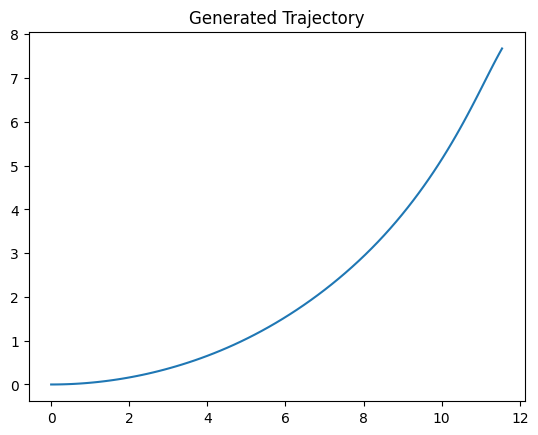

In [2]:
def dsdt(t,s):
  mass,I_z = 1,1
  alpha,beta = 0,0
  x,x_dot,y,y_dot,theta,theta_dot,thrust,thrust_dot,moment,moment_dot = s
  return [
    x_dot,
    thrust*np.cos(theta)/mass,
    thrust*np.sin(theta)/mass,
    theta_dot,
    moment/I_z,
    thrust_dot,
    alpha,
    moment_dot,
    beta
  ]
# Define the system of ODEs
def odes(t, y, T, M):
  x, y, theta, x_dot, y_dot, theta_dot = y
  m = 1  # Mass
  Iz = 1  # Moment of inertia

  x_ddot = T * np.cos(theta) / m
  y_ddot = T * np.sin(theta) / m
  theta_ddot = M / Iz

  return [x_dot, y_dot, theta_dot, x_ddot, y_ddot, theta_ddot]

# Define the objective function to minimize
def objective(params):
  T, M = params

  # Initial and final conditions
  y0 = [0, 0, 0, 0, 0, 0]  # [x, y, theta, x_dot, y_dot, theta_dot] at t=0
  time = np.linspace(0,10,100)

  # Solve the ODEs
  sol = solve_ivp(odes, [min(time),max(time)] , y0, args=(T, M), t_eval=time)

  # Calculate the final position
  xf, yf, thetaf, _, _, _ = sol.y[:, -1]

  # Calculate the cost (distance from the final position to the target)
  cost = (xf - 10)**2 + (yf - 10)**2 + (thetaf - np.pi)**2

  return cost

# Bounds for T and M
bounds = [(0, 1), (-1, 1)]

# Initial guess
x0 = [0.5, 0.5]

# Minimize the objective function
result = minimize(objective, x0, bounds=bounds)

# Optimal values for T and M
optimal_T, optimal_M = result.x

print("Optimal T:", optimal_T)
print("Optimal M:", optimal_M)

time = np.linspace(0,10,100)
intial_conditions = [0, 0, 0, 0, 0, 0]  # [x, y, theta, x_dot, y_dot, theta_dot] at t=0
T = optimal_T
M = optimal_M
optimized_solution = solve_ivp(odes, [0,max(time)],y0=intial_conditions,args=(T,M),t_eval=time)
print((optimized_solution.y).shape)
plt.plot(optimized_solution.y[0],optimized_solution.y[1])
plt.title('Generated Trajectory')

In [3]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from keras.models import Sequential
from tqdm.notebook import tqdm
from keras.layers import Dense
from numpy import pi
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

def createTraj():
  fhat = Sequential()
  fhat.add(Dense(50, activation="sigmoid", input_dim=1))
  fhat.add(Dense(1))
  return fhat

x = createTraj()
y = createTraj()
theta = createTraj()
thrust = createTraj()
moment = createTraj()

2024-03-17 22:53:02.998092: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-17 22:53:03.024699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 22:53:03.024723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 22:53:03.025333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 22:53:03.030993: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-17 22:53:04.192842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 22:53:04.192872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 22:53:04.198500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 22:53:04.198538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 22:53:04.198552: I external/local_xla/xla/stream_executor

In [4]:
initial_time = 0
final_time = 1
number_of_points = 20
normalize_time = tf.cast(tf.linspace(initial_time,final_time,number_of_points),dtype=tf.float32)
def errors(t):
  mass = 1
  I_z = 1
  with tf.GradientTape(persistent=True) as tape1:
    tape1.watch(t)
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch(t)
      X = x(t)
      Y = y(t)
      TH = theta(t)
      THRUST = thrust(t)
      MOMENT = moment(t)
    Xd = tape2.gradient(X, t)
    Yd = tape2.gradient(Y, t)
    THd = tape2.gradient(TH, t)

  # Compute the derivatives
  Xdd = tape1.gradient(Xd, t)
  Ydd = tape1.gradient(Yd, t)
  THdd = tape1.gradient(THd, t)

  # Error in dynamics
  e_xddot = tf.reduce_sum((tf.reshape(Xdd, shape=(number_of_points, 1)) - Xdd * tf.cos(TH)/mass) ** 2)
  e_yddot = tf.reduce_sum((tf.reshape(Ydd, shape=(number_of_points, 1)) - Ydd * tf.sin(TH)/mass) ** 2)
  e_thetaddot = tf.reduce_sum((tf.reshape(THdd, shape=(number_of_points, 1)) - MOMENT/I_z) ** 2)
  e_xdot = tf.reduce_sum((tf.reshape(Xd,shape=(number_of_points,1)) - Xd*tf.cos(TH))**2)
  e_ydot = tf.reduce_sum((tf.reshape(Yd,shape=(number_of_points,1)) - Yd*tf.sin(TH))**2)
  # Error in initial condition
  x0 = 0
  y0 = 0
  th_0 = 0
  x_dot_0 = 0
  y_dot_0 = 0
  th_dot_0 = 0
  thrust_0 = 0
  moment_0 = 0
  eIC = (X[0] - x0) ** 2 + (Y[0] - y0) ** 2 + (TH[0]) ** 2 + (THRUST[0]-thrust_0 )** 2 + (MOMENT[0] - moment_0)**2 # start from (x0,y0) at rest and pointing east

  # Error in final condition
  xf = 1
  yf = 1
  th_f = 0
  x_dot_f = 0
  y_dot_f = 0
  th_dot_0 = 0
  thrust_f = 0
  moment_f = 0
  eFC = (X[-1] - xf) ** 2 + (Y[-1] - yf) ** 2 + (TH[-1] - np.pi) ** 2 + (THRUST[-1]- thrust_f)** 2 + (MOMENT[-1]-moment_f)**2

  return e_xddot + e_yddot + e_thetaddot + 10 * eIC + 10 * eFC # e_xdot + e_ydot 

2024-03-17 22:53:14.416438: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [5]:
run_counter = 0
tolerance = 10**-3
while errors(normalize_time) >= tolerance:
    nIter = 400
    run_counter += 1
    if run_counter == 20:
        print('Failed to converge')
        break
    if errors(normalize_time) <= tolerance*10**4:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    elif errors(normalize_time) <= 0.5*tolerance*10**4:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    elif errors(normalize_time) <= tolerance*10**3:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    elif errors(normalize_time) <= tolerance*10**2:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
    elif errors(normalize_time) <= tolerance*10:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.000001)
    else:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
    for i in tqdm(range(nIter),desc=f"Training run {run_counter}"):
        with tf.GradientTape(persistent=True) as tape:
            e = errors(normalize_time)
        if e <= tolerance:
            print('Finish Training')
            break
    
        # Update parameters in x
        grads = tape.gradient(e, x.trainable_variables)
        optimizer.apply_gradients(zip(grads, x.trainable_variables))

        # Update parameters in y
        grads = tape.gradient(e, y.trainable_variables)
        optimizer.apply_gradients(zip(grads, y.trainable_variables))

        # Update parameters in th
        grads = tape.gradient(e, theta.trainable_variables)
        optimizer.apply_gradients(zip(grads, theta.trainable_variables))

        # Update parameters in thrust
        grads = tape.gradient(e, thrust.trainable_variables)
        optimizer.apply_gradients(zip(grads, thrust.trainable_variables))

        # Update parameters in moment
        grads = tape.gradient(e, moment.trainable_variables)
        optimizer.apply_gradients(zip(grads, moment.trainable_variables))

    print(f"Last error: {round(float(errors(normalize_time)[0]),4)}")

Training run 1:   0%|          | 0/400 [00:00<?, ?it/s]

Last error: 0.0023


Training run 2:   0%|          | 0/400 [00:00<?, ?it/s]

Last error: 0.0015


Training run 3:   0%|          | 0/400 [00:00<?, ?it/s]

Finish Training
Last error: 0.001


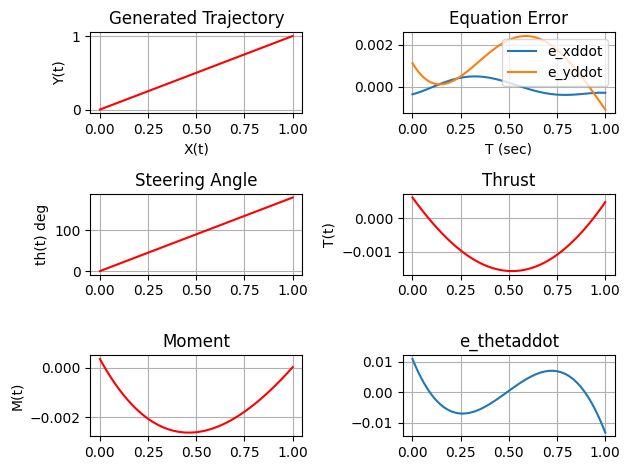

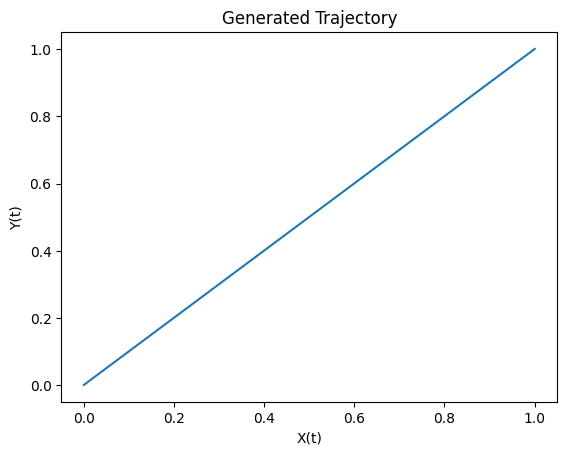

In [6]:
nPts1 = 100
TT = tf.cast(tf.linspace(0,final_time,nPts1),dtype=tf.float32)
tt = TT.numpy()

with tf.GradientTape(persistent=True) as tape1:
  tape1.watch(TT)
  with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(TT)
    X = x(TT)
    Y = y(TT)
    TH = theta(TT)
    THRUST = thrust(TT)
    MOMENT = moment(TT)
  Xd = tape2.gradient(X, TT)
  Yd = tape2.gradient(Y, TT)
  THd = tape2.gradient(TH, TT)

# Compute the derivatives
Xdd = tape1.gradient(Xd, TT)
Ydd = tape1.gradient(Yd, TT)
THdd = tape1.gradient(THd, TT)

e_xddot = tf.reshape(Xdd,shape=(nPts1,1)) - thrust(TT)*tf.cos(theta(TT))
e_yddot = tf.reshape(Ydd,shape=(nPts1,1)) - thrust(TT)*tf.sin(theta(TT))
e_thetaddot = tf.reshape(THdd, shape=(nPts1, 1)) - moment(TT)


r2d = 180/pi

plt.subplot(3,2,1); plt.plot(X.numpy(),Y.numpy(),'r'); plt.grid('on'); plt.xlabel('X(t)'); plt.ylabel('Y(t)'); plt.title('Generated Trajectory')
plt.subplot(3,2,2); plt.plot(tt,e_xddot,label='e_xddot'); plt.grid('on'); plt.title('Equation Error'); plt.xlabel('T (sec)') 
plt.subplot(3,2,2); plt.plot(tt,e_yddot,label='e_yddot'); plt.grid('on'); 
plt.legend()
plt.subplot(3,2,3); plt.plot(tt,theta(TT).numpy()*r2d,'r'); plt.grid('on');plt.ylabel('th(t) deg'); plt.title('Steering Angle')
plt.subplot(3,2,4); plt.plot(tt,thrust(TT).numpy(),'r'); plt.grid('on');plt.ylabel('T(t)'); plt.title('Thrust')
plt.subplot(3,2,5); plt.plot(tt,moment(TT).numpy(),'r'); plt.grid('on');plt.ylabel('M(t)'); plt.title('Moment')
# plt.subplot(3,2,6); plt.plot(tt,thrust(TT).numpy(),'r'); plt.grid('on');plt.ylabel('T(t)'); plt.title('Thrust(t)')
plt.subplot(3,2,6); plt.plot(tt,e_thetaddot,label='e_thetaddot'); plt.grid('on'); plt.title('e_thetaddot')
#plt.tight_layout()
plt.tight_layout()
plt.show()
plt.plot(x(TT).numpy(),y(TT).numpy());  plt.xlabel('X(t)'); plt.ylabel('Y(t)'); plt.title('Generated Trajectory')
plt.show()